## **Get data**

In [ ]:
! mkdir ~/.kaggle

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download joebeachcapital/57651-spotify-songs

Dataset URL: https://www.kaggle.com/datasets/joebeachcapital/57651-spotify-songs
License(s): DbCL-1.0
100% 20.5M/20.5M [00:01<00:00, 22.6MB/s]
100% 20.5M/20.5M [00:01<00:00, 15.9MB/s]


In [ ]:
 ! unzip 57651-spotify-songs

Archive:  57651-spotify-songs.zip
  inflating: Spotify Million Song Dataset_exported.csv  



- самые популярные темы (название тем узнать у импортированого гпт 2)
- для топ 10 исполнителей (кто чаще встерчает в датасете) найти самые популярные темы в их песнях (ищем топ - value_counts(), после распеределения тем для треков, берём все треки популярных, через словарь находим топ тем для каждого исплонителя)


------------------------

# *Imports*

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


pd.options.display.max_colwidth = 300 # increase the number of output characters

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


---------------------------------

# Data preparation

In [ ]:
df = pd.read_csv('Spotify Million Song Dataset_exported.csv')

In [ ]:
df.columns

Index(['artist', 'song', 'link', 'text'], dtype='object')

In [ ]:
df = df.drop('link', axis=1)

In [ ]:
df = df.rename(columns={'text':'lyrics'})

In [ ]:
df['texts'] = pd.Series([f"{n} {l}" for n, l in zip(df['song'], df['lyrics'])])

In [ ]:
df.texts.head()

,texts
0,"Ahe's My Kind Of Girl Look at her face, it's a wonderful face \nAnd it means something special to me \nLook at the way that she smiles when she sees me \nHow lucky can one fellow be? \n \nShe's just my kind of girl, she makes me feel fine \nWho could ever believe that she could be mine? \..."
1,"Andante, Andante Take it easy with me, please \nTouch me gently like a summer evening breeze \nTake your time, make it slow \nAndante, Andante \nJust let the feeling grow \n \nMake your fingers soft and light \nLet your body be the velvet of the night \nTouch my soul, you know how \nAnd..."
2,"As Good As New I'll never know why I had to go \nWhy I had to put up such a lousy rotten show \nBoy, I was tough, packing all my stuff \nSaying I don't need you anymore, I've had enough \nAnd now, look at me standing here again 'cause I found out that \nMa ma ma ma ma ma ma ma ma ma ma ma m..."
3,"Bang Making somebody happy is a question of give and take \nYou can learn how to show it so come on, give yourself a break \nEvery smile and every little touch \nDon't you know that they mean so much \nSweet sweet kisses so tender \nAlways will return to sender \n \nLike a bang, a boom-a-..."
4,"Bang-A-Boomerang Making somebody happy is a question of give and take \nYou can learn how to show it so come on, give yourself a break \nEvery smile and every little touch \nDon't you know that they mean so much \nSweet sweet kisses so tender \nAlways will return to sender \n \nLike a ban..."


# Preproc texts

## Clean texts

In [ ]:
def clean_lyrics(text):
    text = text.lower()
    text = re.sub(r'[{}]'.format(string.punctuation), ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\n', ' ', text)
    return text

In [ ]:
df['clean_texts'] = df['texts'].apply(clean_lyrics)

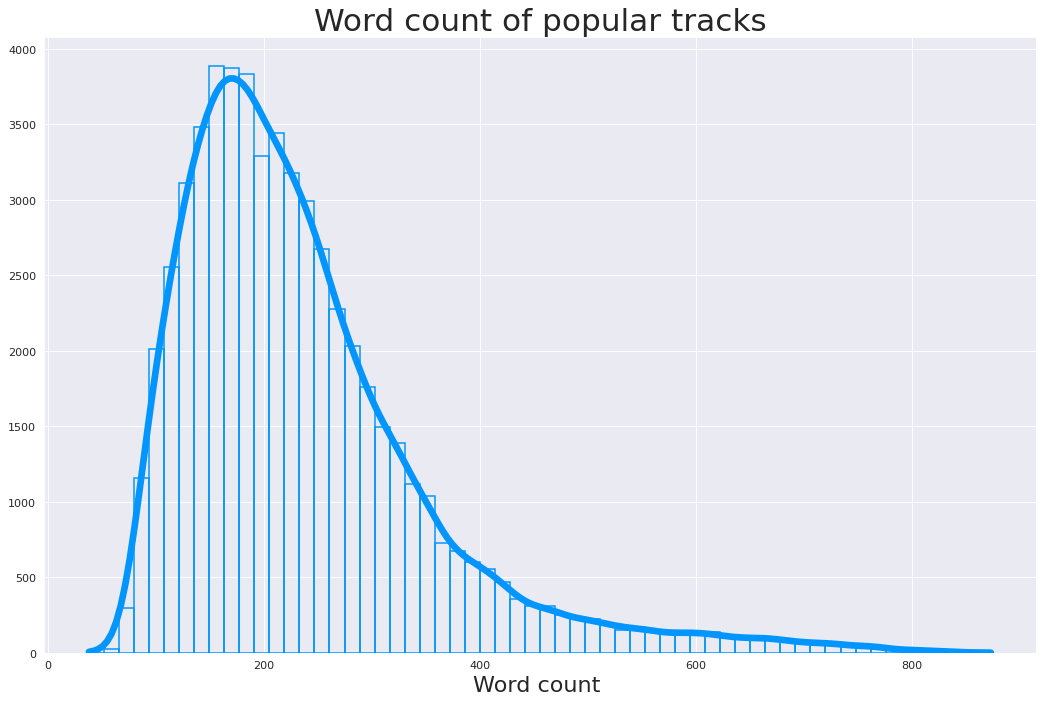

In [ ]:
sns.set_style('darkgrid')
data_for_plot = df['clean_texts'].apply(lambda text: len(text.split()))
plt.figure(figsize=(16,10), dpi= 80)
sns.histplot(data_for_plot, fill=False, bins=60, kde=True, line_kws={'lw': 6}, color='#0095ff')
plt.title("Word count of popular tracks", fontsize=28, fontweight=3)
plt.ylabel('')
plt.xlabel('Word count ', fontsize=20)
plt.show()

________________________

## Not all popular songs are in English, lets detect language for each song and transalte it to English if it neccesary

In [ ]:
!pip install langdetect

In [ ]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

df['language'] =df['texts'].apply(detect)

In [ ]:
# f = open('t.txt').read().split('\n')
# df['language'] = pd.Series(f)

### Let's see which languages are the most common in the lyrics.

In [ ]:
df['language'].value_counts()

,count
language,
en,57192
tl,137
id,92
fr,35
so,34
it,34
de,24
es,23
sw,21


### What are the most popular languages for songs after English?

In [ ]:
!pip install squarify

<ipython-input-92-571bc34bdd92>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = data_for_plot.apply(lambda x: str(x[0]) + " (" + str(x[1]) + ")", axis=1)


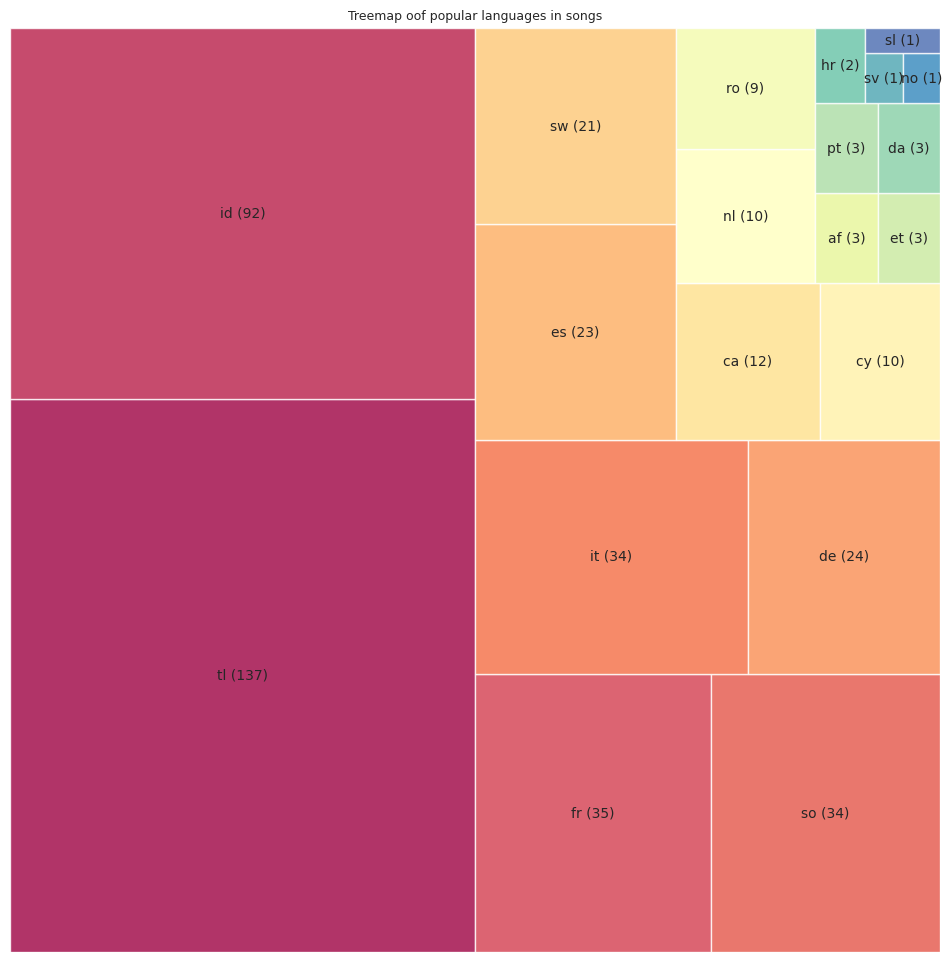

In [ ]:
import squarify

data_for_plot = df['language'].value_counts().drop('en').reset_index()

labels = data_for_plot.apply(lambda x: str(x[0]) + " (" + str(x[1]) + ")", axis=1)
sizes = data_for_plot['count'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]


plt.figure(figsize=(12,12))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

# Decorate

plt.title('Treemap oof popular languages in songs', fontsize=9)
plt.axis('off')
plt.show()

### Okey, lets translate them

In [ ]:
# !pip install googletrans==3.1.0a0

  Using cached googletrans-3.1.0a0.tar.gz (19 kB)
  Preparing metadata (setup.py) ... done
  Using cached httpx-0.13.3-py3-none-any.whl.metadata (25 kB)
  Using cached hstspreload-2024.8.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached chardet-3.0.4-py2.py3-none-any.whl.metadata (3.2 kB)
  Using cached idna-2.10-py2.py3-none-any.whl.metadata (9.1 kB)
  Using cached rfc3986-1.5.0-py2.py3-none-any.whl.metadata (6.5 kB)
  Using cached httpcore-0.9.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached h11-0.9.0-py2.py3-none-any.whl.metadata (8.1 kB)
  Using cached h2-3.2.0-py2.py3-none-any.whl.metadata (32 kB)
  Using cached hyperframe-5.2.0-py2.py3-none-any.whl.metadata (7.2 kB)
  Using cached hpack-3.0.0-py2.py3-none-any.whl.metadata (7.0 kB)
Using cached httpx-0.13.3-py3-none-any.whl (55 kB)
Using cached chardet-3.0.4-py2.py3-none-any.whl (133 kB)
Using cached httpcore-0.9.1-py3-none-any.whl (42 kB)
Using cached idna-2.10-py2.py3-none-any.whl (58 kB)
Using cached h2-3.2.0-py2.py3-none-

In [ ]:
from googletrans import Translator, constants

translator = Translator()
df['texts_to_enlish'] = pd.Series([str(translator.translate(text)) if lang!='en' else text for text, lang in zip(df['clean_texts'], df['language'])])

## Clean lyrics from stopwords

In [ ]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['clean_texts_to_enlish'] = df['texts_to_enlish'].apply(lambda text: ' '.join([word for word in text.split() if word not in stop_words]))

## Lemmatize lyrics (it's necessary for thematic modeling)

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
# To improve the quality of the lemmatizer's work, you can mark the part of speech for each word

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatizator(text):
    pos_tagged = nltk.pos_tag(text.split())
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []

    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))

    lemmatized_sentence = " ".join(lemmatized_sentence)

    return lemmatized_sentence

In [ ]:
df['clean_texts_to_enlish'] = df['clean_texts_to_enlish'].apply(lemmatizator)

In [ ]:
f = open('dataframe2.txt').read().split('\n')[:-1]
df['clean_texts_to_enlish'] = f[:]

## Make work cloud

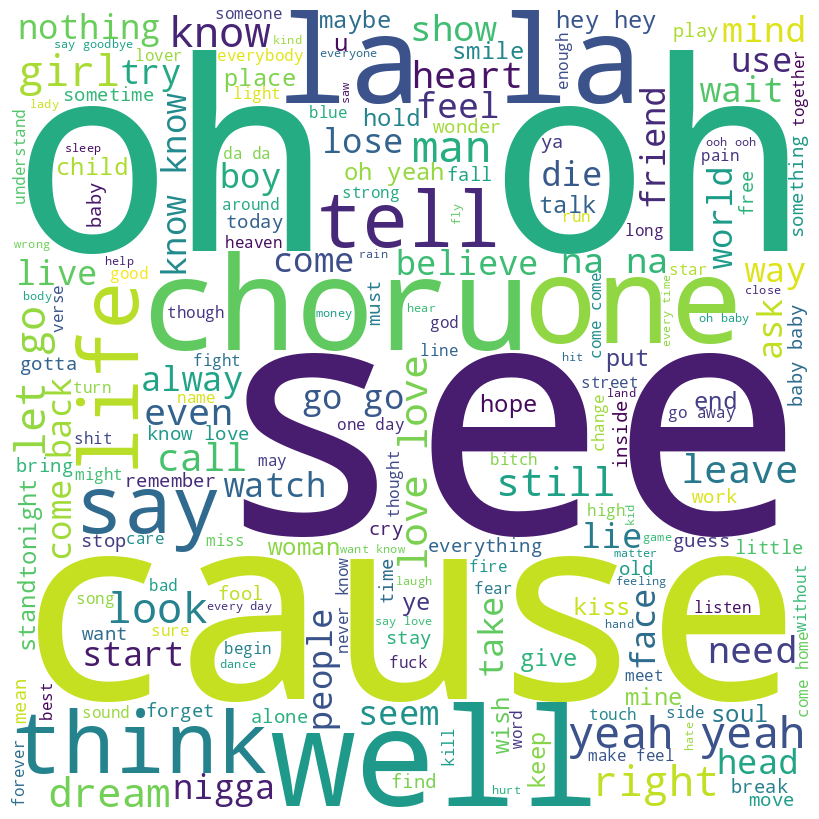

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

comment_words = " ".join(df['clean_texts_to_enlish'])

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

# Tematic modeling

## It's time to find most common topics. I chose the number of topics to be 20, as it gave the best results.

In [ ]:


vectorizer = TfidfVectorizer(max_features=12000)  # Выберите количество признаков
tfidf = vectorizer.fit_transform(df['clean_texts_to_enlish'])

num_of_topics = 20
nmf_model = NMF(n_components=num_of_topics, random_state=42)
nmf_model.fit(tfidf)

# Получение тем
def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(' '.join(topic_words))
    return topics

tfidf_feature_names = vectorizer.get_feature_names_out()
top_topics = display_topics(nmf_model, tfidf_feature_names, 10)  # 10 слов на тему
print("Top 20 themes:")
for i, topic in enumerate(top_topics):
    print(f"Тема {i + 1}: {topic}")

Топ 100 тем:
Тема 1: know need tell see really cause thing show right think
Тема 2: love need true fall forever sweet always kiss darling much
Тема 3: get gotta nigga money ya right cause fuck keep back
Тема 4: oh whoa yes ah ooh night lord please sweet uh
Тема 5: baby ooh night cry please honey babe crazy blue sweet
Тема 6: want need cause live everything tell see give make wanna
Тема 7: la da sing sha fa song na vie ooh de
Тема 8: let us hold tonight show dance snow roll please together
Тема 9: dream night life world see day light eye live sky
Тема 10: christmas merry year day santa tree little bell snow happy
Тема 11: yeah hey ooh alright wanna whoa na ah uh say
Тема 12: go away long home leave way stay round back wrong
Тема 13: gonna tonight right make alright take well cause gotta rock
Тема 14: man good woman well old bad little make boy big
Тема 15: like feel make wanna look way chorus real ya fuck
Тема 16: come back home wait long take call around bring please
Тема 17: time one 

In [ ]:
# Title for each topic

topics_names = {
    '1': 'Life Reflections',
    "2": 'Eternal, Love',
    '3': 'Street Life, Money',
    '4': 'Emotions, Exclamations',
    '5': 'Romance, Passion',
    '6': 'Desires,Aspirations',
    '7': 'Sound Imitations, Melody',
    '8': 'Romantic Evenings, Dancing',
    '9': 'Dreams, Inspiration',
    '10': 'Christmas Holidays',
    '11': 'Energy and Excitement',
    '12': 'Travels, Returns',
    '13': 'Parties, Hangouts',
    '14': 'Characters, Descriptions of People',
    '15': 'Emotions, Relationships',
    '16': 'Waiting, Returning',
    '17': 'Time, Life',
    '18': 'Faith, Farewell',
    '19': 'Heart Dramas',
    '20': 'Youth, Dancing'
}


# Recommendation system

### I tried a slightly different approach in creating a recommender system: instead of vectorizing words, I used topic vectorization. Perhaps because of a better understanding of the context of the song, the recommendation system will give a more balanced result

In [ ]:
# f = open('topics.txt').read().split('\n')
# df['topics'] = pd.Series([i.split(',') for i in f])

In [ ]:
# Присвоение тем текстам
def assign_topics(text_vector):
    topic_distribution = nmf_model.transform(text_vector)
    top_topic_indices = topic_distribution.argsort(axis=1)[:, -5:]  # 5 самых вероятных тем
    return [f"Тема {i + 1}" for i in top_topic_indices[0]]

df['topics'] = [assign_topics(tfidf[i]) for i in range(tfidf.shape[0])]
df['topics'] = df['topics'].apply(lambda topics: [int(topic.split()[1].replace("'", '').replace(']', '')) for topic in topics])

print(df[['clean_texts_to_enlish', 'topics']].head())

                                                                                                                                                                                                                                                                                         clean_texts_to_enlish  \
0  ahe kind girl look face wonderful face mean something special look way smile see lucky one fellow kind girl make feel fine could ever believe could mine kind girl without blue ever leaf could could go walk park hold squeezes hand go walking hour talk thing plan kind girl make feel fine could eve...   
1  andante andante take easy please touch gently like summer evening breeze take time make slow andante andante let feeling grow make finger soft light let body velvet night touch soul know andante andante go slowly music music song song music song play time time make strong play cause make strong ...   
2  good new never know go put lousy rotten show boy tough packing stuff say need a

In [ ]:
 def vector_topics(list_of_topics):
    num_of_topics=20
    topics_in_lyrics = [0]*num_of_topics
    for topic in list_of_topics:
        topics_in_lyrics[topic-1] = 1
    return topics_in_lyrics

In [ ]:
df['vector_topics'] = df['topics'].apply(vector_topics)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

user_tracks = range(5) # just random list of nums
user_topics = df.iloc[user_tracks]['vector_topics'].to_list()

user_profile = np.mean(user_topics, axis=0)

similarity_scores = []
for ind in range(len(df)):
    vector_for_track = np.array(df['vector_topics'].iloc[ind])
    similarity = cosine_similarity([user_profile], [vector_for_track])[0][0]
    similarity_scores.append((ind, similarity))


In [ ]:
df['index'] = pd.Series(range(df.shape[0]))

In [ ]:
df['similarity'] = [score for track_id, score in similarity_scores]

recommended_tracks = df[~df.index.isin(user_tracks)]
recommended_tracks = recommended_tracks.sort_values('similarity', ascending=False)


def show_data(data, i):
    return [print(f"{e1} - {e2}") for e1, e2 in zip(data['artist'].iloc[user_tracks], data['song'].iloc[user_tracks])]

print("You've been listening: ")
show_data(df, user_tracks)
print('You might like')
show_data(recommended_tracks, range(3))

You've been listening: 
ABBA - Ahe's My Kind Of Girl
ABBA - Andante, Andante
ABBA - As Good As New
ABBA - Bang
ABBA - Bang-A-Boomerang
You might like
Eddie Cochran - A Healer Like Time
Rihanna - Stupid In Love
Faith Hill - I Would Be Stronger Than That
Arrogant Worms - Trichinosis
Keith Urban - If Ever I Could Love


[None, None, None, None, None]

# And some more graphs

## Top 25 artists on the chart

<class 'numpy.int64'>


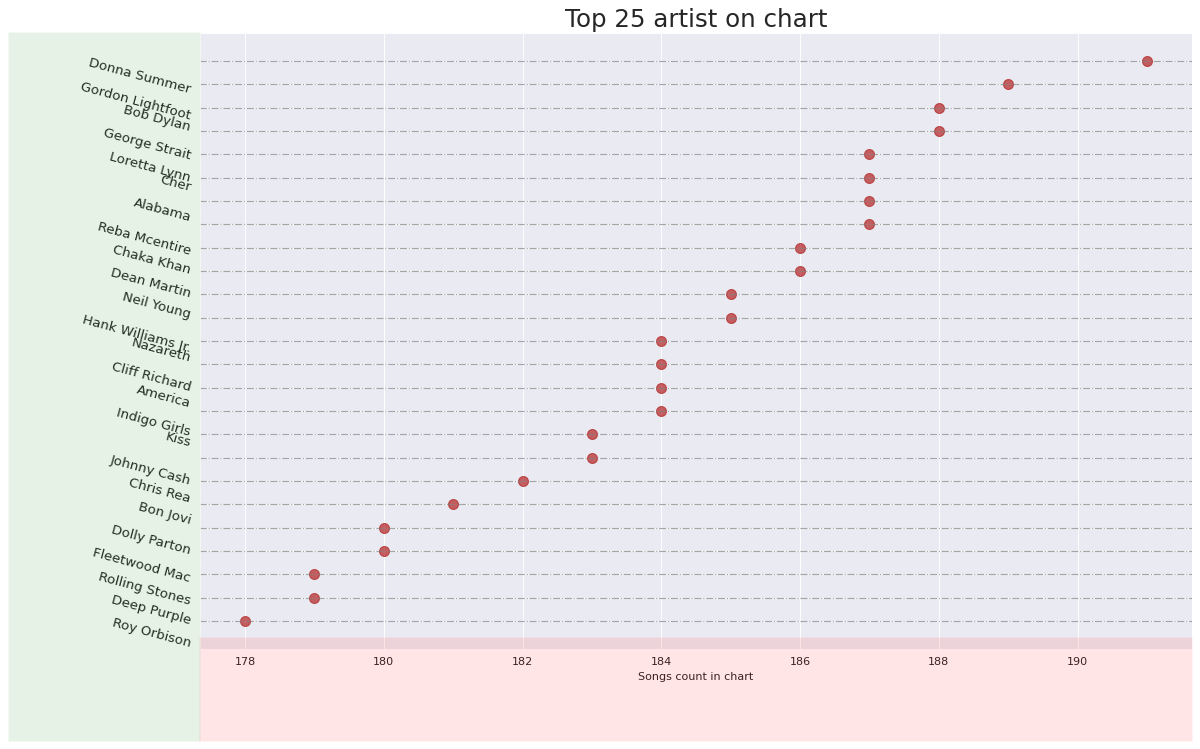

In [ ]:
data_for_plot = df['artist'].value_counts()[:25].sort_values().reset_index()
top25 = data_for_plot['artist']


fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
print(type(data_for_plot['count'].max()))

ax.hlines(y=data_for_plot.index, xmin=data_for_plot['count'].min()*0.9, xmax=data_for_plot['count'].max()*1.1, color='gray', alpha=0.7, linewidth=1, linestyles='dashdot')
ax.scatter(y='artist', x='count', data=data_for_plot, s=80, color='firebrick', alpha=0.7)

ax.set_title('Top 25 artists on the chart', fontdict={'size':22})
ax.set_xlabel('Songs count in chart')
ax.set_yticks(data_for_plot.index)
ax.set_yticklabels(data_for_plot.artist.str.title(), fontdict={'horizontalalignment': 'right'})
plt.yticks(rotation=-15, size=12)
p1 = patches.Rectangle((.124, -0.005), width=0.776, height=.13, alpha=.1, facecolor='red', transform=fig.transFigure)
p2 = patches.Rectangle((-0.025, -0.005), width=0.15, height=0.8865, alpha=.1, facecolor='green', transform=fig.transFigure)
fig.add_artist(p1)
fig.add_artist(p2)
plt.show()

## Most common themes in songs by artists in the top 25

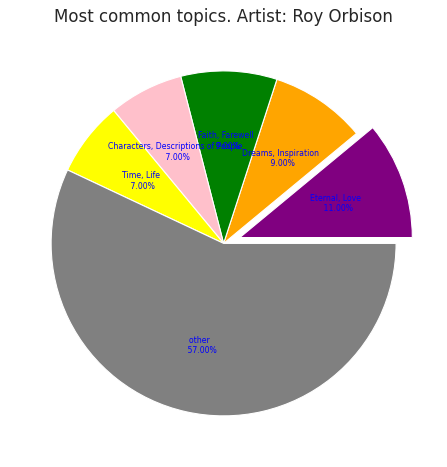

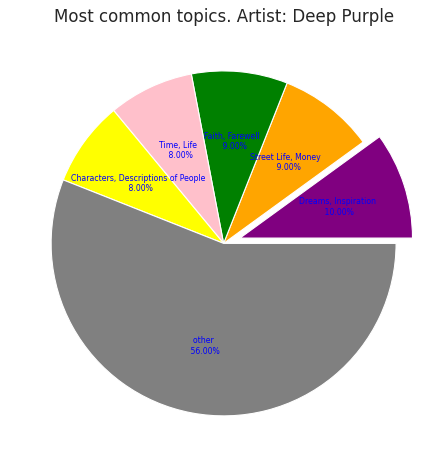

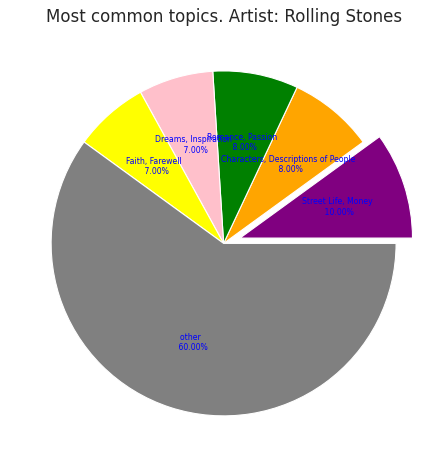

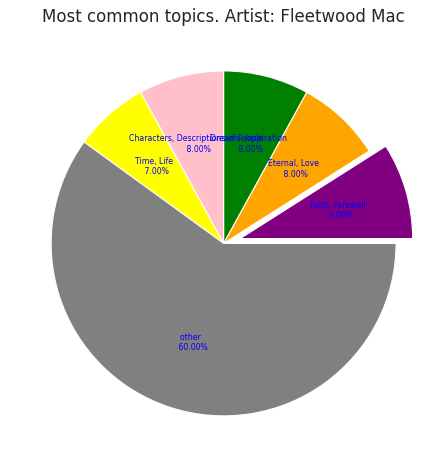

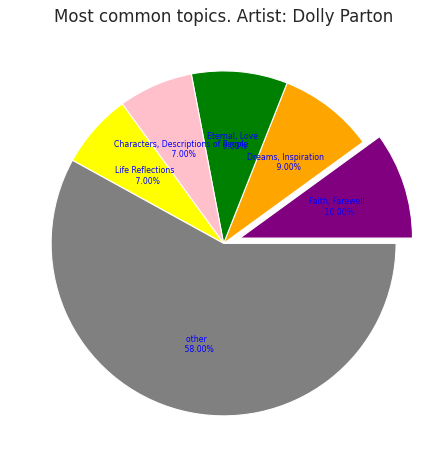

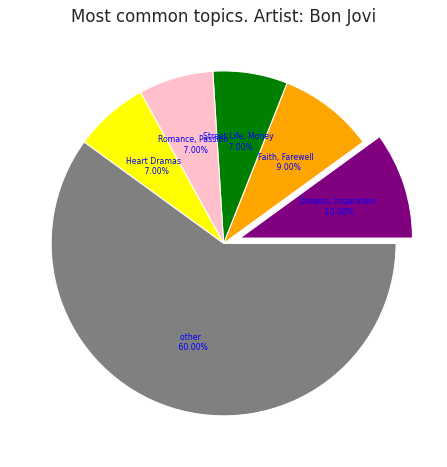

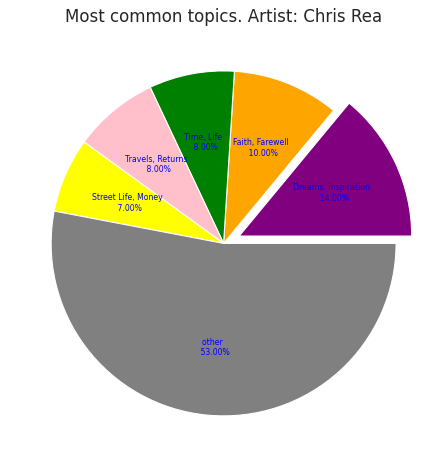

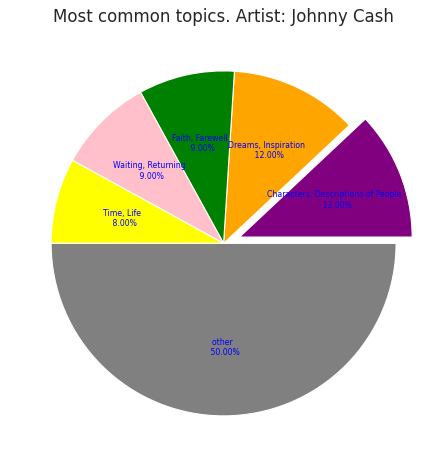

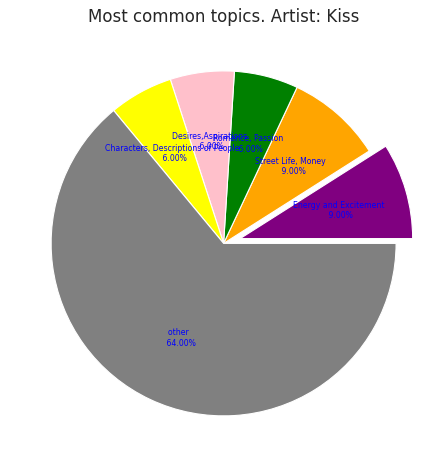

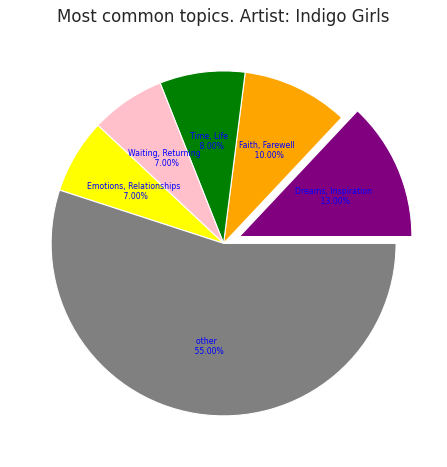

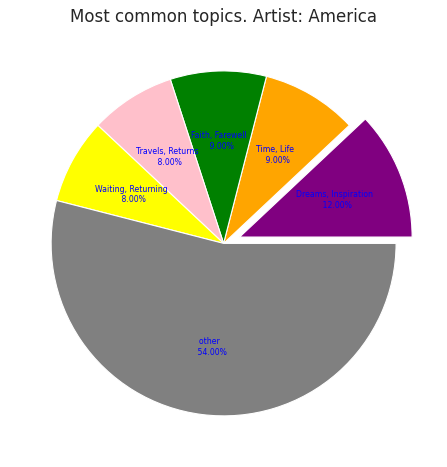

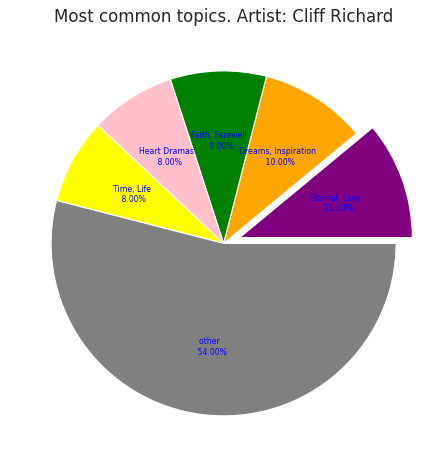

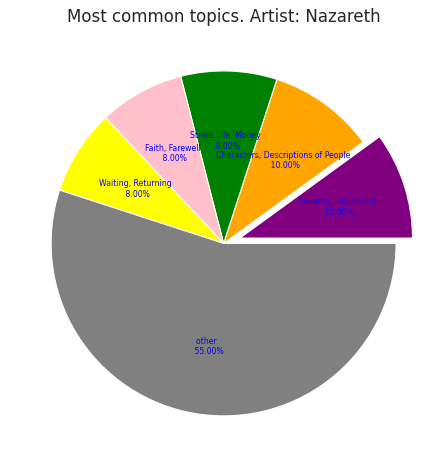

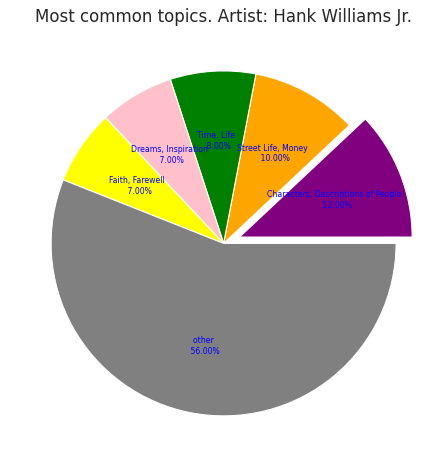

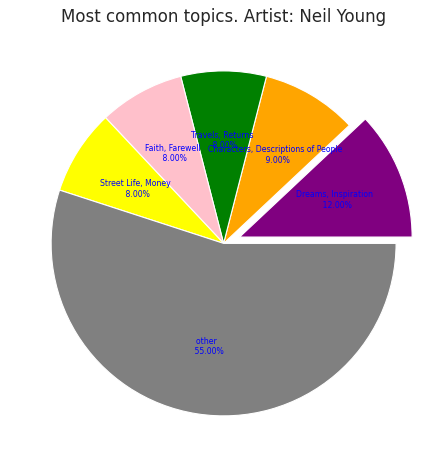

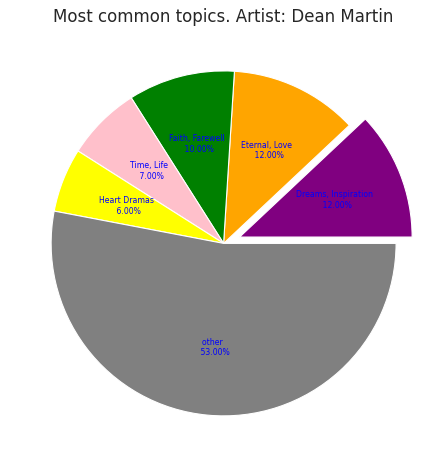

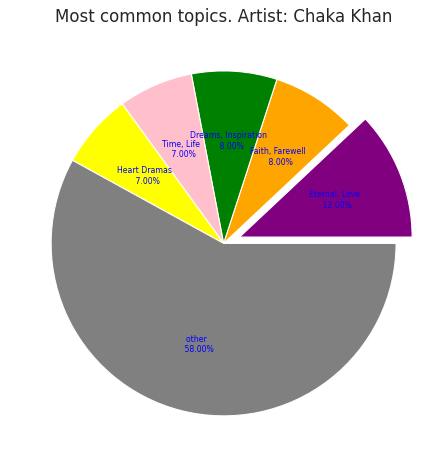

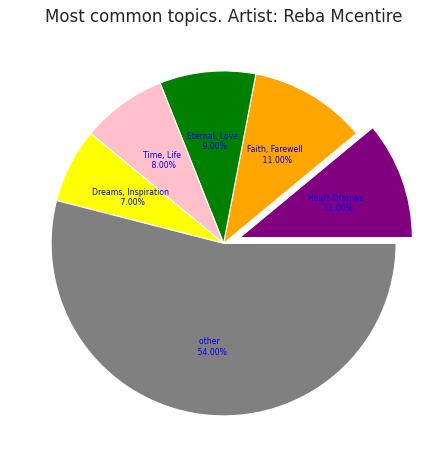

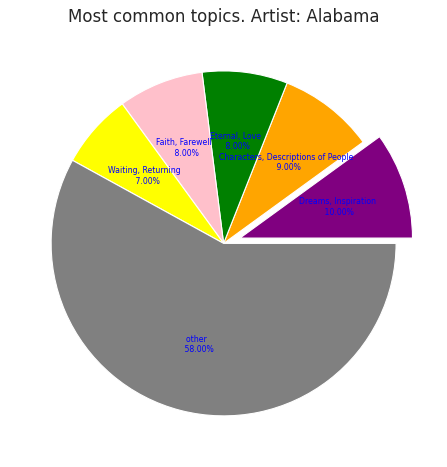

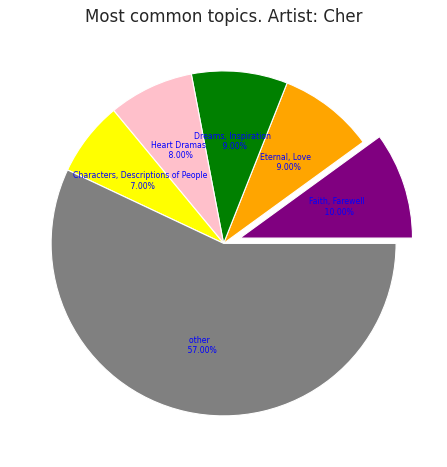

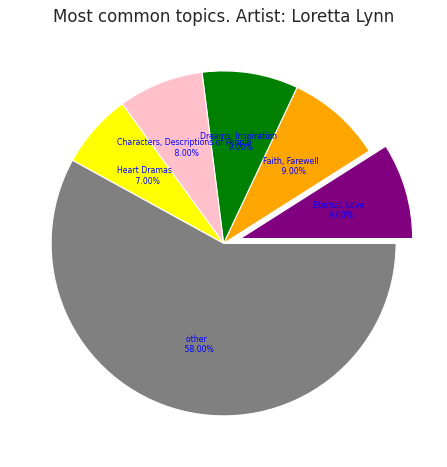

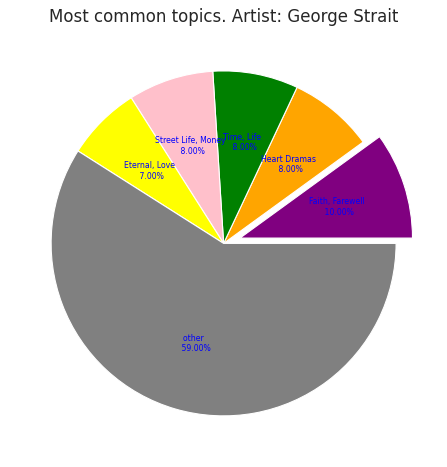

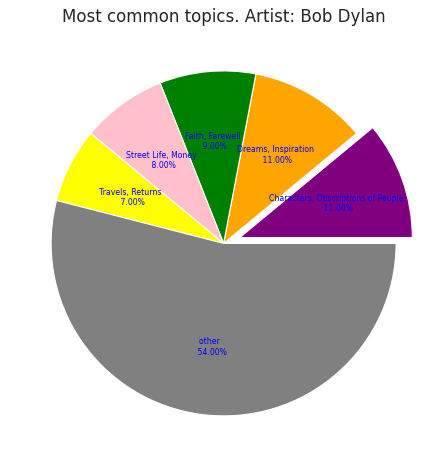

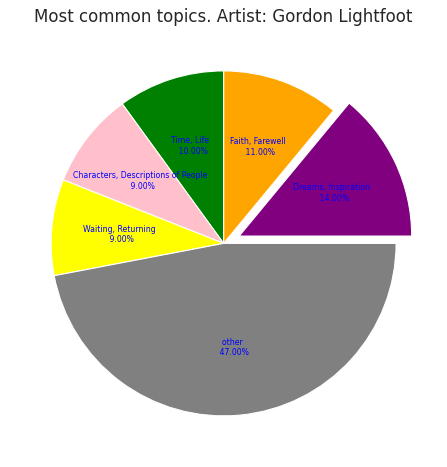

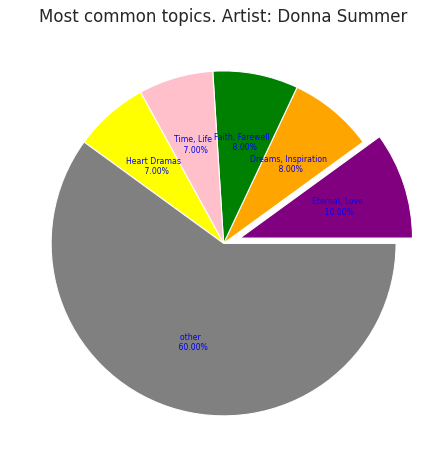

In [ ]:
def find_best_topics(list_of_topics):
    dict_of_topics = {topic_num: list_of_topics.count(topic_num) for topic_num in list(set(list_of_topics))}
    dict_of_topics = sorted(dict_of_topics.items(), key=lambda item: item[1], reverse=True)[:5]
    dict_of_topics = dict({topic_num: round(val/len(list_of_topics), 2) for topic_num, val in dict_of_topics})
    dict_of_topics = {topics_names[str(k)]: v for k, v in dict_of_topics.items()}
    dict_of_topics['other'] = 1-sum([i[1] for i in dict_of_topics.items()])
    return dict_of_topics


data_for_plot = df[['artist', 'topics']].groupby('artist').sum()
data_for_plot['topics'] = data_for_plot['topics'].apply(find_best_topics)



for artist in top25:
    data_for_plot_2 = pd.DataFrame(data_for_plot.loc[artist]['topics'].items(), columns=['topic_num', 'percent'])
    topics, data = data_for_plot_2['topic_num'], data_for_plot_2['percent']

    fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 80)

    explode = [0.1]+[0]*(len(data)-1)
    used_topics = []
    def func(data_for_plot_2, pct):
        data_for_plot_2['most_sim'] = [abs(i*100-pct) for i in data_for_plot_2['percent']]
        data_for_plot_2 = data_for_plot_2.sort_values(by='most_sim').reset_index()
        for i in range(len(data_for_plot_2)):
            topic = data_for_plot_2.iloc[i]['topic_num']
            if topic not in used_topics:
                used_topics.append(topic)
                break
        return "{} \n {:.2f}%".format(topic, pct)


    colors = ['purple', 'orange', 'green', 'pink', 'yellow', 'grey']
    wedges, texts, autotexts = ax.pie(data,
                                      autopct=lambda pct: func(data_for_plot_2, pct),
                                      textprops=dict(color="blue"),
                                      colors=colors,
                                      explode=explode)


    plt.setp(autotexts, size=7, weight=480)
    plt.title(f"Most common topics. Artist: {artist}", fontsize=15, fontweight=80)
    plt.show()
    print()


# Thank you for your attention! ✊